<a href="https://colab.research.google.com/github/theviderlab/computer_vision/blob/main/Faster_R_CNN_con_Detectron2_Backbone_CVNet_Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instalación de dependencias
!pip install -q torch torchvision torchaudio
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-v4jqcpsy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/

In [ ]:
from google.colab import drive
import json
import sys
import matplotlib.pyplot as plt
import torch
import os
from collections import OrderedDict
from detectron2.layers import ShapeSpec
from detectron2.modeling.backbone import Backbone
from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file
from detectron2.engine import DefaultTrainer
from detectron2.modeling.backbone.fpn import FPN, LastLevelMaxPool
from detectron2.data import DatasetCatalog, MetadataCatalog
from cvnet.cvnet_model import CVNet_Rerank

In [ ]:
# 2. Montaje de Google Drive y definición de rutas
drive.mount('/content/drive', force_remount=True)

base_path = "/content/drive/MyDrive/ViderLab/06 - INFORMACIÓN/Capacitación/Master/TFM/Código/"

cvnet_path = base_path + "image_retrieval/backbones/"
pretrained_weights_path = base_path + "assets/weights/CVPR2022_CVNet_R50.pyth"

# Paths para Open Images subset
dataset_path = base_path + "assets/database/open-images"
images_path = dataset_path + "/images"
json_path = dataset_path + "/annotations_touristic_detectron2.json"

output_dir = base_path + "/assets/weights/faster_r-cnn_cvnet_finetuned_openimages"

In [ ]:
# 3. Carga del JSON ya convertido para Detectron2
with open(json_path, 'r') as f:
    converted = json.load(f)

In [ ]:
# 4. Registro del dataset en Detectron2 Registro del dataset en Detectron2
DatasetCatalog.register("openimages_touristic", lambda: converted)
MetadataCatalog.get("openimages_touristic").set(thing_classes=thing_classes)

namespace(name='paris_train_cvnet_v1', thing_classes=['landmark'])

In [ ]:
# 5. Definición del wrapper CVNetBottomUp para FPN para FPN
sys.path.append(cvnet_path)

class CVNetBottomUp(Backbone):
    def __init__(self, cvnet):
        super().__init__()
        self.cvnet = cvnet
    def forward(self, x):
        return self.cvnet.extract_backbone_stages(x)
    def output_shape(self):
        return {
            "res2": ShapeSpec(channels=256, stride=4),
            "res3": ShapeSpec(channels=512, stride=8),
            "res4": ShapeSpec(channels=1024, stride=16),
            "res5": ShapeSpec(channels=2048, stride=32),
        }

In [ ]:
# 6. Configuración base de Detectron2 y desactivación de pesos ResNet
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.RESNETS.DEPTH = 50
cfg.MODEL.WEIGHTS = ""  # Sin pesos predefinidos

In [ ]:
# 7. Carga de CVNet_Rerank y sus pesos
cvnet = CVNet_Rerank(RESNET_DEPTH=50, REDUCTION_DIM=2048)
full_checkpoint = torch.load(pretrained_weights_path, map_location='cpu')
state_dict = full_checkpoint.get('model_state', full_checkpoint)
cvnet.load_state_dict(state_dict, strict=False)
cvnet = cvnet.cuda()

In [ ]:
# 8. Congelamiento del backbone y construcción de FPN
for param in cvnet.parameters(): param.requires_grad = False
cvnet.eval()
cvnet_backbone = CVNetBottomUp(cvnet)
backbone = FPN(
    bottom_up=cvnet_backbone,
    in_features=["res2","res3","res4","res5"],
    out_channels=256,
    top_block=LastLevelMaxPool(),
    fuse_type="sum"
)
cfg.MODEL.BACKBONE.FREEZE_AT = 5

In [ ]:
# 9. Configuración de entrenamiento y ejecución
cfg.DATASETS.TRAIN = ("paris_train_cvnet_v1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = output_dir
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005
cfg.SOLVER.MAX_ITER = 30000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.model.backbone = backbone
trainer.model.to(torch.device("cuda"))
trainer.resume_or_load(resume=False)

[05/06 17:11:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
trainer.train()

[05/06 17:11:31 d2.engine.train_loop]: Starting training from iteration 0
[05/06 17:11:37 d2.utils.events]:  eta: 2:17:24  iter: 19  total_loss: 5.112  loss_cls: 2.822  loss_box_reg: 0.02266  loss_rpn_cls: 0.7562  loss_rpn_loc: 0.9965    time: 0.2708  last_time: 0.2103  data_time: 0.0179  last_data_time: 0.0033   lr: 9.9905e-07  max_mem: 1973M
[05/06 17:11:43 d2.utils.events]:  eta: 2:19:15  iter: 39  total_loss: 1.86  loss_cls: 0.4116  loss_box_reg: 0.01938  loss_rpn_cls: 0.6245  loss_rpn_loc: 0.6333    time: 0.2812  last_time: 0.2603  data_time: 0.0087  last_data_time: 0.0063   lr: 1.998e-06  max_mem: 1973M
[05/06 17:11:49 d2.utils.events]:  eta: 2:19:31  iter: 59  total_loss: 1.711  loss_cls: 0.3989  loss_box_reg: 0.02265  loss_rpn_cls: 0.5758  loss_rpn_loc: 0.4402    time: 0.2799  last_time: 0.3240  data_time: 0.0076  last_data_time: 0.0045   lr: 2.997e-06  max_mem: 1973M
[05/06 17:11:54 d2.utils.events]:  eta: 2:18:19  iter: 79  total_loss: 1.352  loss_cls: 0.3316  loss_box_reg: 0

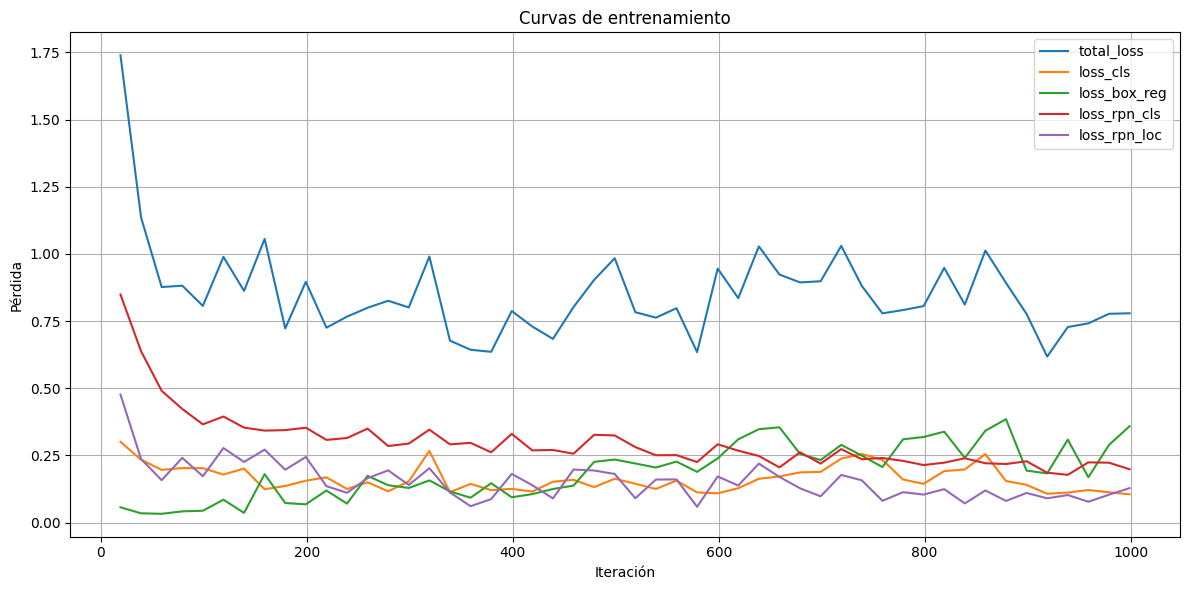

In [ ]:
# 10. Lectura y graficado de métricas de entrenamiento
metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
metrics = []
with open(metrics_path) as f:
    for line in f:
        if line.strip() and not line.startswith("{\"iteration\": 0"):
            metrics.append(json.loads(line))
iterations = [m["iteration"] for m in metrics]
keys_to_plot = ["total_loss","loss_cls","loss_box_reg","loss_rpn_cls","loss_rpn_loc"]
plt.figure(figsize=(12,6))
for key in keys_to_plot:
    plt.plot(iterations, [m.get(key) for m in metrics], label=key)
plt.xlabel("Iteración")
plt.ylabel("Pérdida")
plt.title("Curvas de entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()